In this exercise, we compare the RiskMetrics VaR to the (Weighted) Historical Simulation approach. We compare the time patterns of the three VaR measures applied to S&P 500 index returns in the period January 2001 through December 2010. Next, we evaluate the three approaches using backtests.

In [1]:
import numpy as np
import pandas as pd
!pip install pandas_datareader
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os                     

Efficient programming of the Weighted Historical Simulation method requires a function that can deliver weighted percentiles from a sample. The code for this has been found on the web, and imported here.

In [2]:
def weighted_quantile(values, quantiles, sample_weight=None, values_sorted=False, old_style=False):
    """ Source: https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
    Very close to np.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: np.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of initial array
    :param old_style: if True, will correct output to be consistent with np.percentile.
    :return: np.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    if not values_sorted: 
        sorter = np.argsort(values) # Gives indices of sorted 'values'; sorting is in ascending order
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style: # 'if False' means does not execute this statement in this block 
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0] # subtract first element
        weighted_quantiles /= weighted_quantiles[-1] # divide by last element
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

Data loading, using pandas datareader connected to Yahoo! Finance.
Note that after creating the returns series R:
* observations 0:250 refer to year 2000, used to start up (W)HS
* observations 251:2765 refer to 2001-2010, evaluation sample

In [3]:
st = dt.datetime(2000, 1, 1) # start of the sample
en = dt.datetime(2010, 12, 31) # end of the sample
data = web.DataReader('^GSPC', 'yahoo', start=st, end=en)
S = data['Adj Close'] # from series we choose Adjusted Close price:  is the closing price after adjustments for all applicable splits and dividend distributions.
R = 100 * np.log(1 + S.pct_change().dropna()) # define percentage growth (100 like scaling)
R.name = 'R' # define the name of constructed series

In [14]:
np.log(1 +S.pct_change().dropna())
1 +S.pct_change().dropna()

Date
2000-01-04    0.961655
2000-01-05    1.001922
2000-01-06    1.000956
2000-01-07    1.027090
2000-01-10    1.011190
                ...   
2010-12-27    1.000613
2010-12-28    1.000771
2010-12-29    1.001009
2010-12-30    0.998492
2010-12-31    0.999809
Name: Adj Close, Length: 2766, dtype: float64

When the above code does not run properly, replace the previous block by the following, which loads the data from the provided csv file; otherwise, skip this block.

In [4]:
 #dframe = pd.read_csv('SP500.csv', parse_dates=True, index_col='Date')
 #S = dframe['SP500']
 #R = 100 * np.log(1 + S.pct_change().dropna())
 #R.name = 'R'

### Question 1

Calculate the 1%, one-day VaR for S&P 500 index returns for each day in the evaluation period (January 2001 through December 2010), using each of the three methods, and keep the result in three vectors / arrays. To get started, this code below already contains the definition of a weight vector w, based on a historical period m = 250, and a parameter $\lambda = \eta = 0.94$ for the WHS and RM methods. Note that WHS and the $\sigma_{t+1}$ sequence in RM need a start-up sample period, for which we use data from the year 2000 (252 observations).

*Note*: an easy way to implement the RM method to construct $\sigma_t^2$ is to use the `series.ewm()` function from `pandas`. Note that in that function, $\alpha = 1 - \lambda$, and also that you need to apply this to the *lagged* squared return (so using the `series.shift()` function).

In [5]:
p = 0.01 # probability for VaR
labda = 0.94 # RM
m = 250 # historical period
eta = labda # WHS
tau = np.arange(m,0,-1) # 'm' is the starting point, '0' is the end point (not including), '-1' is the step size (you move backwards)
w = eta**tau # Take exponent
w /= sum(w) # Weights are sorted from low to high

Rsq = (R**2).shift(1) # lagged squared return
sigma2 = Rsq.ewm(alpha=1-labda).mean() # compute variance
sigma = np.sqrt(sigma2)['1/1/2001':'12/31/2010'] # compute volatility; add datetime index
VaR_RM = pd.Series(-sigma*stats.norm.ppf(0.01), name='VaR RM') # you create pandas Series (like a column in a table); one-dimensional array

VaR_HS = pd.Series(0*R, name='VaR HS')   # declare a new series, pandas Series
for t in range(m,len(R)): # 'm' is included, 'len(R)' is not included
    VaR_HS[t] = -np.percentile(R[t-m:t],1) # 1 percentile
VaR_HS = VaR_HS['1/1/2001':'12/31/2010'] 

VaR_WHS = pd.Series(0*R, name='VaR WHS') # declare a new series, pandas Series
for t in range(m,len(R)):
    VaR_WHS[t] = -weighted_quantile(R[t-m:t],p,w) # function defined above, input elements: series, quantiles, weights
VaR_WHS = VaR_WHS['1/1/2001':'12/31/2010'] 

In [27]:
p = 0.01 # probability for VaR
labda = 0.94 # RM
m = 250 # historical period
eta = labda # WHS
tau = np.arange(m,0,-1) #
tau
w = eta**tau;w
w /= sum(w);w
Rsq = (R**2).shift(1);Rsq
sigma2 = Rsq.ewm(alpha=1-labda).mean();
Rsq.ewm(alpha=1-labda).mean()
sigma = np.sqrt(sigma2); sigma

Date
2000-01-04         NaN
2000-01-05    3.909918
2000-01-06    2.725130
2000-01-07    2.190769
2000-01-10    2.332663
                ...   
2010-12-27    0.700353
2010-12-28    0.679184
2010-12-29    0.658764
2010-12-30    0.639173
2010-12-31    0.620803
Name: R, Length: 2766, dtype: float64

### Question 2

Make a figure where each of the three VaR measures are plotted against time. Discuss the similarities and differences.

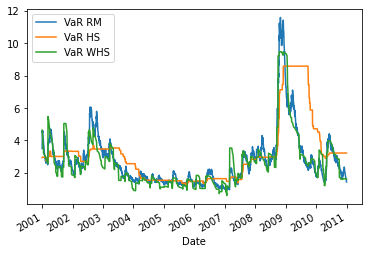

In [6]:
plt.figure(figsize=(6, 4))
VaR_RM.plot()
VaR_HS.plot()
VaR_WHS.plot()
plt.legend()

We observe the usual “ghosting” behaviour of HS, in particular after the financial crisis of 2008: the VaR stays high for exactly a year. I contrast, RM and WHS are similar to each other; they reduce gradually after the crisis. The peaks in the RM VaR seem a bit higher than the WHS VaR.

### Question 3

Investigate the effect of changing the eta ($\eta$) parameter in the WHS method: what happens if
we give eta a value very close to 1, e.g. 0.999?

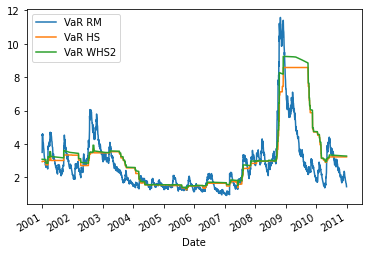

In [7]:
eta = 0.999
w = eta**tau
w /= sum(w)
VaR_WHS2 = pd.Series(0*R, name='VaR WHS2')
for t in range(m,len(R)):
    VaR_WHS2[t] = -weighted_quantile(R[t-m:t],p,w)
VaR_WHS2 = VaR_WHS2['1/1/2001':'12/31/2010']
plt.figure(figsize=(6, 4))
VaR_RM.plot()
VaR_HS.plot()
VaR_WHS2.plot()
plt.legend()

For $\eta$ very close to 1, we observe that the difference between WHS and HS vanishes.

In [8]:
!jupyter nbconvert --to html ComputerExercise1Solution.ipynb 

[NbConvertApp] Converting notebook ComputerExercise1Solution.ipynb to html
[NbConvertApp] Writing 663198 bytes to ComputerExercise1Solution.html
